## Create Dataset Synthetic Handwriting on Cartoon Images

### Create COCO dataset
JSON

In [1]:
outpath_train = "dataset\\train\\images"
outpath_test = "dataset\\test\\images"

In [2]:
import os

try:
    os.mkdir("dataset")
except (FileExistsError):
    pass
except Exception as e:
    raise e
    
try:
    os.mkdir("dataset\\train")
except (FileExistsError):
    pass
except Exception as e:
    raise e

try:
    os.mkdir("dataset\\test")
except (FileExistsError):
    pass
except Exception as e:
    raise e

try:
    os.mkdir("dataset\\train\\images")
except (FileExistsError):
    pass
except Exception as e:
    raise e

try:
    os.mkdir("dataset\\test\\images")
except (FileExistsError):
    pass
except Exception as e:
    raise e


In [3]:
mypath = "Pictures\\train\\"

In [4]:
from scipy import io as sio
import emnist
import matplotlib.pyplot as plt
from random import random
import random
import numpy as np
import cv2

from os import listdir,stat
from os.path import isfile, join

# Read text
### Dubliner's text file

In [5]:
lines = [line.rstrip('\n') for line in open("dubliners.txt") if ((len(line)>1) and (random.randint(0,10000) >= 995))]
lines = [" ".join(a.split()) for a in lines]

## Emnist has handwritten characters

In [6]:
images, labels = emnist.extract_training_samples('letters')

### Index Emnist because labels are shuffled

In [7]:
lettere = []
for a in range(0,27):
    lettere.append( [x for x in range(len(labels)) if (labels[x]==a)] )

In [8]:
def writeletter(character):
    asc = ord(character.upper())
    
    if asc<64:
        if asc==32:
            return None
        
    else:
        tret = asc-64
        
        if tret<27:
            lr = random.choice(lettere[tret])
            return images[lr]
        else:
            return None
    
    

## Bubble text creation
### Returns
#### 1 .Text with Ellipse
#### 2 .Bitmap Mask 
#### 3 .ROI for text - each line of text is an ROI

In [9]:
def bubble_text(**kwargs):
    
    c = kwargs.get('sent_no', None)
    if c is None:
        sent_no = random.randint(0,len(lines)-1)
    else:
        sent_no = c
    
    sentence = lines[sent_no]+"\n"+lines[sent_no+1]+" "
    img = np.zeros([560,560],dtype=np.uint8)*255
    x=0
    y=0
    xmax = 0
    cnt = 0
    roi = []
    
    ## top left corner of area 
    (px,py) = (x,y)
    
    for a in sentence:
        cnt = cnt + 1
        if ord(a)==32:
            ## wordwrap
            x = x + 28
            xmax = max (xmax,x)
            nextspace = sentence[cnt:].find(' ')
            #print(nextspace,nextspace*28+x+28,y,sentence[cnt:])
            if (nextspace*28+x+28)>559:
                y=y+28
                roi.append([(px,py),(x,y)]) ## thats's your box
                x=0
                (px,py)=(x,y)
            
        else:
            chimg = writeletter(a)
            if chimg is not None:
                img[y:y+28,x:x+28]=chimg
            x = x +28
            xmax = max (xmax,x)
            if x>559:
                y=y+28
                roi.append([(px,py),(x,y)]) ## thats's your box
                x=0
                (px,py)=(x,y)
                
    y=y+28
    roi.append([(px,py),(x,y)]) ## thats's your box
    
    img = img[0:y,0:xmax]
    boundary = 100
    yboundary = 80
    
    bubble = np.zeros([y + yboundary ,xmax + boundary ],dtype=np.uint8)*255
    bubble = cv2.ellipse(bubble, ((xmax+boundary) >> 1,(y+yboundary) >> 1), \
                         ((xmax+boundary) >> 1,(y+yboundary) >> 1), 0, 0,360, 255, 2)
    
    mask = np.zeros([y + yboundary ,xmax + boundary ],dtype=np.uint8)*255
    mask = cv2.ellipse(mask, ((xmax+boundary) >> 1,(y+yboundary) >> 1), \
                         ((xmax+boundary) >> 1,(y+yboundary) >> 1), 0, 0,360, 255, -1)
    kernel = np.ones((5,5),np.uint8)
    mask = cv2.dilate(mask,kernel)
    
    boundary = boundary >> 1
    yboundary = yboundary >> 1
    bubble[yboundary:y+yboundary,boundary:xmax+boundary] = img
    #print(sent_no,sentence)
    
    return bubble,mask,roi

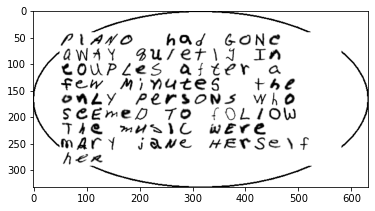

In [10]:
bbl_text,mask,roi = bubble_text(sent_no=4514)
plt.imshow(bbl_text, cmap='gray_r');

In [11]:
print(roi)

[[(0, 0), (448, 28)], [(0, 28), (448, 56)], [(0, 56), (448, 84)], [(0, 84), (476, 112)], [(0, 112), (476, 140)], [(0, 140), (476, 168)], [(0, 168), (420, 196)], [(0, 196), (532, 224)], [(0, 224), (112, 252)]]


In [12]:
def paste_im_with_mask(bg,fg,mask,y,x):
    (yy,xx) = fg.shape
    bg[y:y+yy,x:x+xx]=fg*mask+(1-mask)*bg[y:y+yy,x:x+xx]
    
    return bg

### MRCNN directory 
    dataset
        - train
           *.jpg
           train.json
        - val
            *.jpg
            val.json
            
JSON - mrcnn Balloon dataset


In [13]:
def becolon(a,b,c):
    return "\""+a+"\":\""+b+"\""+c+"\n"

def cecolon(a,b,c):
    return "\""+a+"\":"+b+c+"\n"

def oncolon(a,b):
    return "\""+a+"\":"+b+"\n"

def recolon(a,b):
    return "\""+a+"\":{}"+b+"\n"

def line_out(filename,size_x,size_y,image_index):
    return  '   { \n\
      "license": 0, \n\
      "file_name": "'+filename+'", \n\
      "width":  '+str(size_x)+', \n\
      "height": '+str(size_y)+', \n\
      "id": '+str(image_index)+' \n\
    },'
    
    

def anno_out(image_index,alpx,alpy):
    maxx = alpx[0][0] ## max X coord of mask
    x0 = alpx[0][0] ## top left corner of mask
    y0 = alpy[0][0]
    
    
    segmask = str(x0)+"," +str(y0)+", "
    for x in range(len(alpx)):
        segmask = segmask + str(alpx[x][1])+"," +str(alpy[x][1])+", "
        segmask = segmask + str(alpx[x][1])+"," +str(alpy[x][2])+", "
        
        if maxx< alpx[x][1]:
            maxx = alpx[x][1]
        
    maxy =  alpy[x][2] ## max Y coord of mask
    
    segmask = segmask + str(x0)+"," +str(maxy)+", "
    segmask = segmask + str(x0)+"," +str(y0)
    
    bbox = str(alpx[0][0])+","  + str(alpy[0][0]) + ", " + str(maxx-x0) + ", " + str(maxy-y0)
    
    area = (maxx-x0)*(maxy-y0)
    
    return '{ \n\
      "segmentation": [ \n\
        [ '+segmask+' ] \n\
      ], \n\
      "iscrowd": 0,\n\
      "image_id": '+str(image_index)+',\n\
      "category_id": 1, \n\
      "id": '+str(image_index)+',\n\
      "bbox": [ ' + bbox + ' ],\n\
      "area": '+str(area)+'\n\
    },'
    
    
    
    
    
  

In [14]:
trainjson = '{ \n\
  "info": { \n\
    "description": "Synthetic ComicBook text", \n\
    "url": "http://github/mische", \n\
    "version": "1.0", \n\
    "year": 2021, \n\
    "contributor": "MicSche", \n\
    "date_created": "2021/03/21" \n\
  }, \n\
  "licenses": [ \n\
    { \n\
      "url": "http://ww.ahab/com/seamen", \n\
      "id": 0, \n\
      "name": "Non-Commercial Educational " \n\
    } \n\
  ], \n\
  "images": ['
testjson = trainjson

trainAnno = ''
testAnno = ''

supercat='  ],\n\
  "categories": [\n\
    {\n\
      "supercategory": "text",\n\
      "id": 1,\n\
      "name": "handwritten"\n\
    }\n\
  ]\n\
}'

### Load Pictures from directory: Pictures
output to 
- "dataset_coco\\images\\"


In [15]:
onlyfiles = [join(mypath,f) for f in listdir(mypath) if isfile(join(mypath, f))]

In [16]:
cnt=0
dim = (512, 512)

for a in onlyfiles:
    orig = cv2.imread(a,0)
    # resize image
    img = cv2.resize(orig, dim, interpolation = cv2.INTER_AREA)
    
    (y,x) = img.shape   ## used to locate text bubble
    (my,mx) = img.shape ## used tp create masks
    
    textbbl,mask,roi = bubble_text() 
    textbbl = 255-textbbl
    (yy,xx) = textbbl.shape
    
    ### select from random size 1/6 frame (in 6 positions 1-6 ) or 1/3 frame (in 3 positions 7-9)
    frame_poss = random.randint(1,9)
    if frame_poss < 7 : # reduce text bbl to 1/6 size of image
        y = int(y /3)
        x = int(x /2)
    else:
        y = int(y /3)
        
    scalex = 1.0* (x/xx)
    scaley = 1.0* (y/yy)
    scale = min(scalex,scaley)

    xx = int(xx*scale)
    yy = int(yy*scale)
    roi = [[(int((x1+36)*scale),int((y1+36)*scale)),(int((x2+36)*scale),int((y2+36)*scale))] for [(x1,y1),(x2,y2)] in roi]
    textbbl = cv2.resize(textbbl,(xx,yy))
    mask = cv2.resize(mask,(xx,yy))
    (yy,xx) = textbbl.shape
        
    mask = mask > 127
        
    if frame_poss==1:
        img = paste_im_with_mask(img,textbbl,mask,0,0)
        
    if frame_poss==2:
        img = paste_im_with_mask(img,textbbl,mask,y,0)
        roi = [[(x1,y1+y),(x2,y2+y)] for [(x1,y1),(x2,y2)] in roi]
        
    if frame_poss==3:
        img = paste_im_with_mask(img,textbbl,mask,y << 1,0)
        roi = [[(x1,y1+(y << 1)),(x2,y2+(y << 1))] for [(x1,y1),(x2,y2)] in roi]
        
    if frame_poss==4:
        img = paste_im_with_mask(img,textbbl,mask,0,x)
        roi = [[(x1+x,y1),(x2+x,y2)] for [(x1,y1),(x2,y2)] in roi]
        
    if frame_poss==5:
        img = paste_im_with_mask(img,textbbl,mask,y,x)
        roi = [[(x1+x,y1+y),(x2+x,y2+y)] for [(x1,y1),(x2,y2)] in roi]
        
    if frame_poss==6:
        img = paste_im_with_mask(img,textbbl,mask,y << 1,x)
        roi = [[(x1+x,y1+(y << 1)),(x2+x,y2+(y << 1))] for [(x1,y1),(x2,y2)] in roi]
        
    if frame_poss==7:
        img = paste_im_with_mask(img,textbbl,mask,0,0)
        
    if frame_poss==8:
        img = paste_im_with_mask(img,textbbl,mask,y,0)
        roi = [[(x1,y1+y),(x2,y2+y)] for [(x1,y1),(x2,y2)] in roi]
        
    if frame_poss==9:
        img = paste_im_with_mask(img,textbbl,mask,y << 1,0)
        roi = [[(x1,y1+(y << 1)),(x2,y2+(y << 1))] for [(x1,y1),(x2,y2)] in roi]
        
    ferryx = [[x,x1,x1,x,x] for [(x,y),(x1,y1)] in roi]
    ferryy = [[y,y,y1,y1,y] for [(x,y),(x1,y1)] in roi]
    
    cnt = cnt + 1
    filename = str(cnt)+".jpg"
    
    
    if random.randint(1,10)<8: ## 7/3 train/val
        dfile = join(outpath_train, filename)
        if not cv2.imwrite(dfile,img):
            print(dfile)
        filesize = stat(dfile).st_size
        trainjson = trainjson + line_out(filename,mx,my,cnt)
        trainAnno = trainAnno + anno_out(cnt,ferryx,ferryy)
    else:
        dfile = join(outpath_test, filename)
        if not cv2.imwrite(dfile,img):
            print(dfile)
        filesize = stat(dfile).st_size
        testjson = testjson + line_out(filename,mx,my,cnt)
        testAnno = testAnno + anno_out(cnt,ferryx,ferryy)
        
trainjson = trainjson[:-1]+'],\
  "annotations": [' + trainAnno[:-1]+supercat
testjson  = testjson[:-1]+'],\
  "annotations": [' + testAnno[:-1]+supercat

In [17]:
### Write Train/Val/TrainVal text files
textfile = open(join(outpath_train,"..\\train.json"), "w")
a = textfile.write(trainjson)
textfile.close()

textfile = open(join(outpath_test,"..\\test.json"), "w")
a = textfile.write(testjson)
textfile.close()